In [1]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from collections import OrderedDict
import pandas as pd
import numpy as np
# import os
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
NUM_EPOCH = 30
# NUM_CLASSES = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [4]:
data_file = 'data/ecog_mel60_bi_dataset.pkl'
with open(data_file, 'rb') as f:
    dataset = pickle.load(f)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=dataset[0],
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset[1],
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [7]:
class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out

In [8]:
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out

In [26]:
class ResNet(nn.Module):
 
    def __init__(self, block=BasicBlock, layers=[2, 2, 2, 2], num_classes=384):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc = nn.Linear(512 * block.expansion*2, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        with torch.no_grad():
            x =x
            
        return x

In [27]:
model = ResNet()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Train the model
total_step = len(train_loader)
train_loss_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(NUM_EPOCH):
    model.train()
    for i, (ecog, mel) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)
        
        # Forward pass
#         outputs = model(images).double()
#         labels = labels.long()
        outputs = model(ecog)
        labels = mel
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            train_loss_list.append(loss.item())
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, NUM_EPOCH, loss.item()))
#             model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 for images, labels in test_loader:
#                     images = images.to(device)
#                     labels = labels.to(device)
#                     outputs = model(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 print('Test Accuracy of the model on the 250 test images: {} %'.format(100 * correct / total))
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
#         data, target = Variable(data, volatile=True), Variable(target)
#         data = data.to(device)
#         target = target.to(device)
        output = model(data)
        # sum up batch loss
        target = target
        test_loss += F.l1_loss(output, target, size_average=False).data
        # get the index of the max log-probability
#         pred = output.data.max(1, keepdim=True)[1]
#         correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss.item())
#     test_accuracy_list.append((100. * correct / len(test_loader.dataset)).item())
    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss))
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, NUM_EPOCH, i+1, total_step, loss.item()))
 

Epoch [1/30], Loss: 0.4284

Test set: Average loss: 17.0454

Epoch [2/30], Loss: 0.0294

Test set: Average loss: 7.9152

Epoch [3/30], Loss: 0.0253

Test set: Average loss: 7.4286

Epoch [4/30], Loss: 0.0189

Test set: Average loss: 12.7074

Epoch [5/30], Loss: 0.0200

Test set: Average loss: 7.1201

Epoch [6/30], Loss: 0.0164

Test set: Average loss: 6.3385

Epoch [7/30], Loss: 0.0163

Test set: Average loss: 5.5634

Epoch [8/30], Loss: 0.0150

Test set: Average loss: 5.2053

Epoch [9/30], Loss: 0.0134

Test set: Average loss: 5.8864

Epoch [10/30], Loss: 0.0122

Test set: Average loss: 5.2751

Epoch [11/30], Loss: 0.0118

Test set: Average loss: 10.7786

Epoch [12/30], Loss: 0.0141

Test set: Average loss: 5.5921

Epoch [13/30], Loss: 0.0122

Test set: Average loss: 4.4532

Epoch [14/30], Loss: 0.0122

Test set: Average loss: 5.1356

Epoch [15/30], Loss: 0.0128

Test set: Average loss: 4.3964

Epoch [16/30], Loss: 0.0127

Test set: Average loss: 4.8643

Epoch [17/30], Loss: 0.0119

T

In [29]:
img = dataset[1][1][0].numpy()
# img_arr = np.asarray([t.numpy() for t in img])
img = Variable(torch.from_numpy(img)).view(1,1,96,125)
img = Variable(img).view(1,96,125)
# print(img[95])

In [30]:
mel_out = model(img)

In [32]:
mel_out_np = mel_out.detach().numpy()
mel_out_np = mel_out_np.reshape(128,3)
print(mel_out_np)

[[-6.35715260e-05 -2.37665066e-04 -1.99956179e-04]
 [-4.22817247e-05 -8.51384480e-04  6.69135479e-04]
 [-6.76866854e-04 -3.41626524e-04 -3.80131067e-04]
 [ 2.25098367e-04 -2.25392687e-05 -4.84205142e-04]
 [ 1.47599567e-04 -6.21061481e-05  1.81355703e-04]
 [ 1.08478998e-04 -2.99279083e-04 -1.35424678e-04]
 [ 5.44156297e-04 -4.97276487e-04 -2.41521047e-05]
 [ 3.13280907e-04 -2.47636053e-05  6.63656800e-04]
 [ 1.40021410e-04  1.87441656e-05  1.95429253e-04]
 [-5.27164899e-04  1.45315600e-03  3.20932537e-04]
 [-8.85005938e-05  7.01780606e-04  1.87951155e-04]
 [-4.25760343e-04  9.46979213e-04  2.63859110e-05]
 [-4.04802384e-04  2.58647924e-04  9.63604398e-05]
 [-1.48595063e-04  2.72091711e-04 -1.46773848e-04]
 [ 1.89692000e-04  2.24542673e-04 -1.99105445e-04]
 [ 1.75590976e-04  6.97271258e-04 -4.37682247e-05]
 [ 1.14624749e-03 -4.96457214e-05  7.25985155e-05]
 [ 5.34068327e-04  1.70703366e-04 -5.93399782e-05]
 [-5.56880317e-04 -2.54495535e-05  2.46087497e-04]
 [ 2.12797910e-04  2.33368337e-

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline 

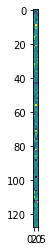

In [34]:
plt.imshow(mel_out_np, interpolation='nearest')
plt.show()

In [65]:
for i, (ecog, mel) in enumerate(train_loader):
    print(mel)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...

In [12]:
test_ecog=[]
for i, (ecog, mel) in enumerate(test_loader):
    test_ecog.append(ecog)

In [25]:
# mel_out = model(test_ecog[199])
print(len(test_ecog))

13


In [14]:
mel_out_np = mel_out.detach().numpy()
print(np.size(mel_out_np))
# mel_out_np = mel_out_np.reshape(128,3)
# print(mel_out_np)
# plt.imshow(mel_out_np, interpolation='nearest')
# plt.show()

6144
